In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

from ase.io import read
from abtem import show_atoms

from abtem.potentials import Potential
from abtem.waves import FresnelPropagator, Probe

from tqdm.auto import tqdm
import copy

C:\Users\Geri\anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


# Probe Propagation in a Si <110> crystal

This example aims to recreate the results from the paper by Voyles et al [1], examining the effect of probe channeling in crystalline <110> silicon columns.

Voyles PM, Grazul JL, Muller DA. *Imaging individual atoms inside crystals with ADF-STEM*. Ultramicroscopy. 2003 Sep;96(3-4):251-73. doi: 10.1016/S0304-3991(03)00092-5. PMID: 12871793.

## 1. Probe situated at the top of an atomic column

C:\Users\Geri\anaconda3\lib\site-packages\ase\io\cif.py:528: UserWarning: CIF v2.0 file format detected; `ase` CIF reader might incorrectly interpret some syntax constructions, use `pycodcif` reader instead
  warnings.warn('CIF v2.0 file format detected; `ase` CIF reader might '


<IPython.core.display.Javascript object>


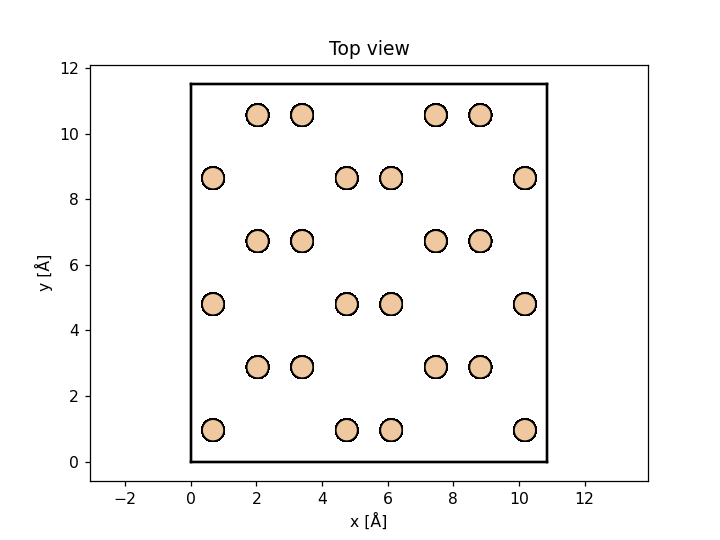

In [2]:
atoms = read('Si_110.cif')
unitcell_dims = atoms.cell.cellpar()[:3]

atoms *= (2, 3, 265)
show_atoms(atoms, title='Top view', scale_atoms=0.3);

In [3]:
main_col = atoms.positions[1101][:2] # x and y of main column
adj_col = atoms.positions[4600][:2] # x and y of adjacent column
print(main_col)
print(adj_col)

# here I wasn't really sure how else I could get the exact positions of the columns in a cleaner way. I just looked
# at the atoms.positions array to manually find the indices for the right columns

[4.75171375 4.79995   ]
[6.10934625 4.79995   ]


In [4]:
cell_dims = atoms.cell.cellpar()[:3]
cell_dims # a, b and c params for the supercell

array([  10.86106,   11.51988, 1017.5894 ])

In [5]:
slice_thickness = unitcell_dims[-1]/10 # used this thickness so there wouldn't be any jagged intensity curves.
potential = Potential(atoms,
                      slice_thickness=slice_thickness,
                      gpts=(256, 256),
                      parametrization='kirkland').build()

In [6]:
probe_on_main_col = Probe(sampling=potential.sampling,
                          gpts=potential.gpts,
                          energy=200e3,
                          semiangle_cutoff=10,
                          focal_spread=30,
                          defocus=450,
                          Cs=1e-3*1e10,
                          device='cpu',
                         ).build(main_col) # placing probe at the top of a column

<IPython.core.display.Javascript object>


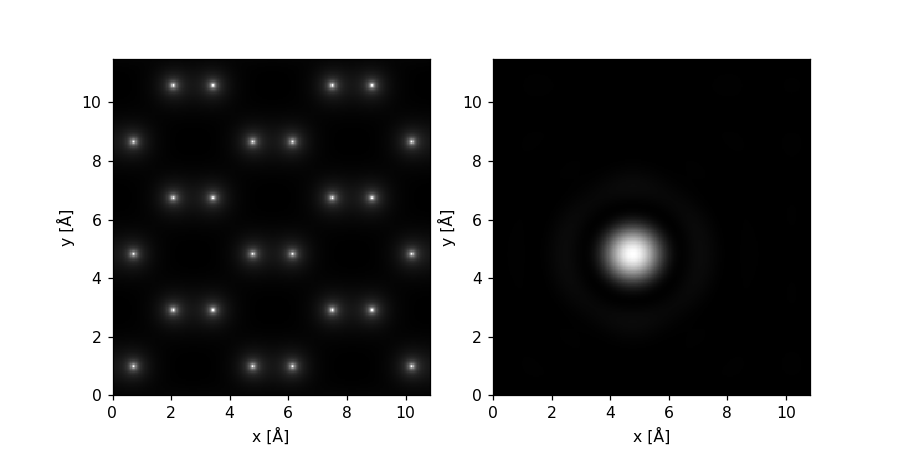

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
potential.project().show(ax=ax1)
probe_on_main_col.show(ax=ax2);

In [10]:
propagation_main_col = run_multislice(potential, probe_on_main_col) # function defined at the bottom

  0%|          | 0/2650 [00:00<?, ?it/s]

In [11]:
main_col_signal = hs.signals.Signal2D(propagation_main_col) # change to Hyperspy signal
main_col_signal

<Signal2D, title: , dimensions: (2650|256, 256)>

In [12]:
fix_axes_data(main_col_signal) # fix axes_manager data to name and scale axes

In [13]:
cross_section = main_col_signal.transpose(signal_axes=['x','z']).inav[main_col[1]]
# take cross section on the x-z plane at the y position where the columns are located

intensity_1D = cross_section.transpose(navigation_axes=['x'])

main_col_intensity = intensity_1D.inav[main_col[0]]
main_col_intensity.metadata.General.title = 'Main column'

adj_col_intensity = intensity_1D.inav[adj_col[0]]
adj_col_intensity.metadata.General.title = 'Adjacent column'

<IPython.core.display.Javascript object>


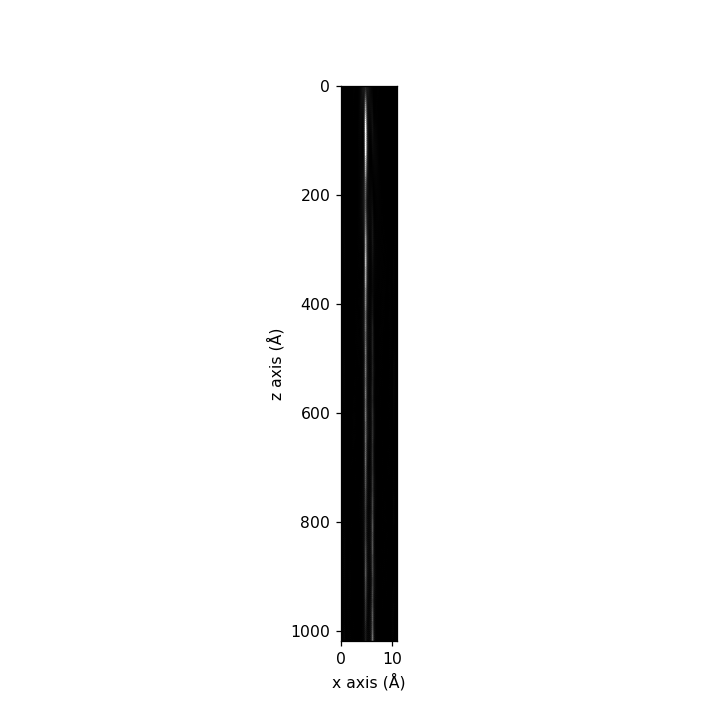

<IPython.core.display.Javascript object>


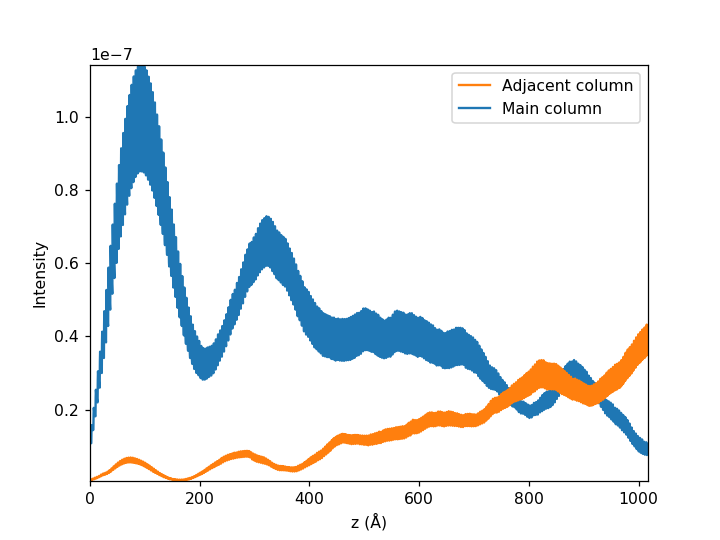

In [14]:
hs.plot.plot_images(cross_section, colorbar=False, suptitle='')
hs.plot.plot_spectra([main_col_intensity, adj_col_intensity], legend='auto');

Tried to do this to put plots alongside each other, didn't work:

In [15]:
# fig, (ax1, ax2) = plt.subplots(1, 2)
# hs.plot.plot_spectra([main_col_intensity, adj_col_intensity], legend='auto', ax=ax1);
# hs.plot.plot_images(cross_section, colorbar=False, suptitle='', ax=ax2)

## 2. Probe situated between atomic columns

In [15]:
probe_between_cols = Probe(sampling=potential.sampling,
                          gpts=potential.gpts,
                          energy=200e3,
                          semiangle_cutoff=10,
                          focal_spread=30,
                          defocus=450,
                          Cs=1e-3*1e10,
                          device='cpu',
                         ).build([(main_col[0]+adj_col[0]) / 2, main_col[1]]) # placing probe between columns

<IPython.core.display.Javascript object>


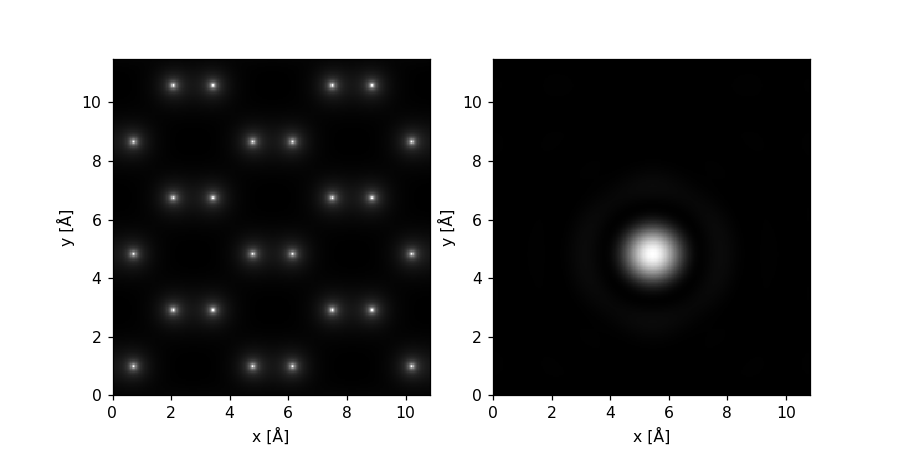

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
potential.project().show(ax=ax1)
probe_between_cols.show(ax=ax2);

In [17]:
propagation_between_cols = run_multislice(potential, probe_between_cols)

  0%|          | 0/2650 [00:00<?, ?it/s]

In [18]:
between_cols_signal = hs.signals.Signal2D(propagation_between_cols)
between_cols_signal

<Signal2D, title: , dimensions: (2650|256, 256)>

In [19]:
fix_axes_data(between_cols_signal)

In [20]:
cross_section = between_cols_signal.transpose(signal_axes=['x','z']).inav[main_col[1]]
# take cross section on the x-z plane at the y position where the columns are located

intensity_1D = cross_section.transpose(navigation_axes=['x'])

main_col_intensity = intensity_1D.inav[main_col[0]]
main_col_intensity.metadata.General.title = 'Main column'

adj_col_intensity = intensity_1D.inav[adj_col[0]]
adj_col_intensity.metadata.General.title = 'Adjacent column'

midpoint_intensity = intensity_1D.inav[(main_col[0]+adj_col[0]) / 2]
midpoint_intensity.metadata.General.title = 'Midpoint'

<IPython.core.display.Javascript object>


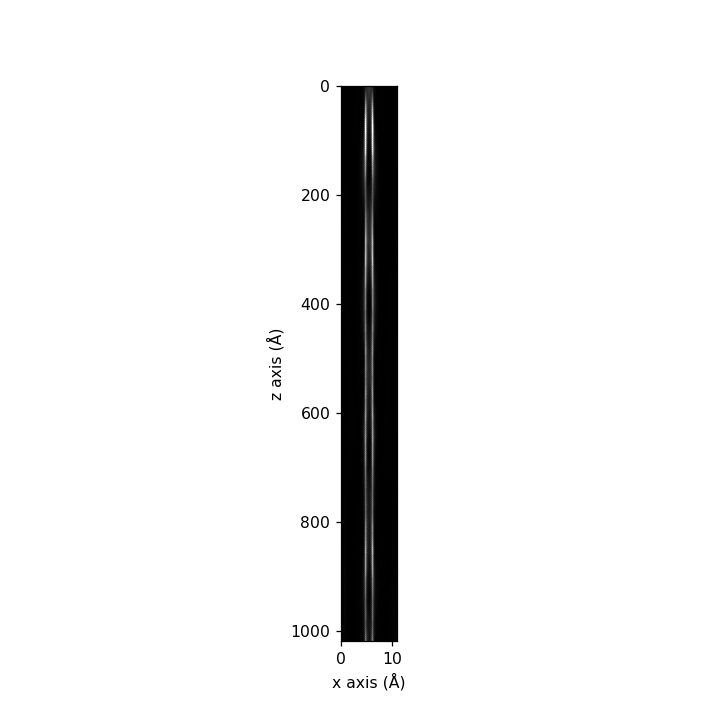

<IPython.core.display.Javascript object>


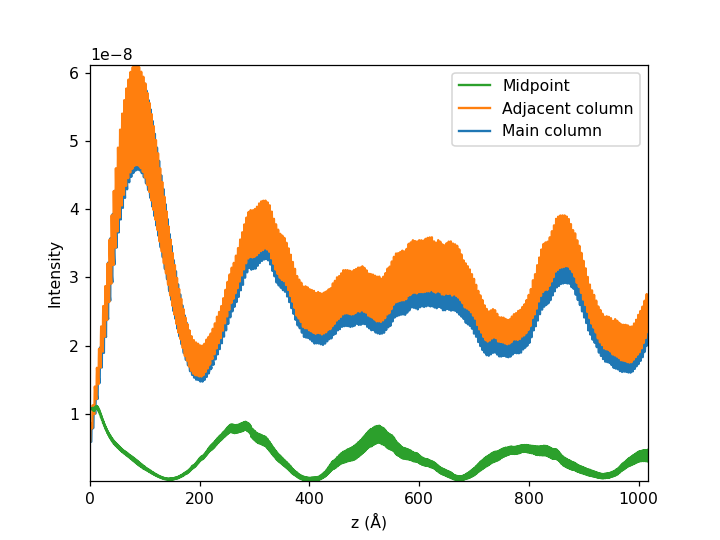

In [21]:
hs.plot.plot_images(cross_section, colorbar=False, suptitle='')
hs.plot.plot_spectra([main_col_intensity, adj_col_intensity, midpoint_intensity], legend='auto');

### Functions:

In [9]:
def run_multislice(potential, probe):
    
    probe_copy = copy.deepcopy(probe)
    n_slices = potential.num_slices
    gpts = potential.gpts
    waves = np.empty((n_slices, gpts[0], gpts[1]), dtype='float64')

    propagator = FresnelPropagator()

    for j in tqdm(range(n_slices)):
        potential[j].transmit(probe_copy)
        propagator.propagate(probe_copy, dz=potential[j].thickness)
        waves[j, :, :] = probe_copy.intensity().array
        
    return waves

def fix_axes_data(signal):

    z_ax = signal.axes_manager.navigation_axes[0]
    y_ax = signal.axes_manager.signal_axes[0]
    x_ax = signal.axes_manager.signal_axes[1]

    z_ax.name = 'z'
    x_ax.name = 'x'
    y_ax.name = 'y'

    z_ax.scale = cell_dims[2] / z_ax.size
    x_ax.scale = cell_dims[0] / x_ax.size
    y_ax.scale = cell_dims[1] / y_ax.size

    z_ax.units = y_ax.units = x_ax.units = 'Å'